#
<span style="font-family: 'Times New Roman'; font-size:20px">
<h1 align=center>
Data Science Project


Sketching and Sampling based methods for Novel
Matrix Factorization
</h1>
</span>

**Problem Statement:** There has been a number of recent results of making SVD/PCA methods more
efficient by employing sampling and and random projection type techniques.
Often, however, the task of prediction calls for a different matrix factorization, e.g.
factoring into non-negative matrices, max-margin matrix factorization,
augmenting SVD based methods to handle incomplete entries. The aim of this
project is to study empirically the effect of some of the sampling techniques on
specific sets of matrix factorization techniques. We will see some of the
sketching/sampling techniques in class.
Some of the interesting matrix factorization methods are n max margin matrix
factorization *(described in http://ttic.uchicago.edu/∼nati/mmmf/)*,
(nonnegative factorization (chapter 2 of this thesis)), other variants are also
available. For most of these matrix factorizations, existing code is available, so no
need to implement those afresh. We will only need to implement the sampling
methods and the evaluation techniques.

###
<span style="font-family: 'Times New Roman'; font-size:20px">
<h3>
What is Matrix Factorization?
</h3>
</span>

<span style="font-family: 'Times New Roman'; font-size:24px">

We have a huge matrix $A$ of size $m \times n$, we want to store this matrix but as it is of huge size, it is not possible to store it in memory. So, we use matrix factorization techniques to store this matrix $A$ by applying some Sampling and Sketching Techniques on the matrix and then by factorizing it into two matrices $U$ and $V'$ of size $m \times k$ and $k \times n$ respectively. We can store these two matrices in memory and can use them to get the original matrix $A$ by multiplying these two matrices $U$ and $V'$. We have to find the best $k$ value for which we can get the original matrix $A$ with minimum error.

$$A = U \times V\ |\ A → m \times n,\ \ \ U → m \times k,\ \ \ V → k \times n$$

But after applying some Sampling and Sketching, we get $U$ and $V'$ instead of $V$, and $A$ can be approximated as:

$$A' = U \times V'\ |\ A \approx A'$$



###
<span style="font-family: 'Times New Roman'; font-size:20px">
<h3>
What is Sketching and Sampling?
</h3>

<span style="font-family: 'Times New Roman'; font-size:24px">

**Sampling:** Sampling is the process of selecting a subset of the data from the original data set. It is used to reduce the size of the data set because we can't store the huge data set in our local devices. So, we need to sample the data set to reduce its size. The methods that we are going to use are:
- Random Sampling
- Stratified Sampling

**Sketching:** Sketching is the process of reducing the dimensionality of the data set. It is used to reduce the number of features of the data set. The methods that we are going to use are:
- Random Projection
- Count Sketch



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from PIL import Image
import os
import warnings
warnings.filterwarnings("ignore")

###
<span style="font-family: 'Times New Roman'; font-size:20px">
<h3>
Loading the Image Matrix for Factorization
</h3>

In [3]:
def load_image(infilename, size=None):
    img = Image.open(infilename)
    img.load()
    img = img.resize(size)
    img = img.convert('L')
    data = np.asarray(img, dtype="int32")
    return data

In [4]:
A = load_image('image2.jpg', size=(1024,1024))

In [5]:
A.shape

(1024, 1024)

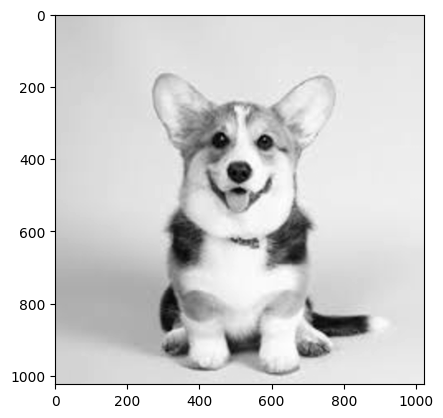

In [6]:
plt.imshow(A, cmap='gray')

##
<span style="font-family: 'Times New Roman'; font-size:20px">
<h3>
Function for applying Non-Negative Matrix Factorization
</h3>

###
<span style="font-family: 'Times New Roman'; font-size:20px">
<h3>
What is Non-Negative Matrix Factorization?
</h3>

<span style="font-family: 'Times New Roman'; font-size:24px">

Non-negative matrix factorization (NMF) is a group of algorithms in multivariate analysis and linear algebra where a matrix $V$ is factorized into (usually) two matrices $W$ and $H$, with the property that all three matrices have no negative elements. This non-negativity makes the resulting matrices easier to interpret, and also non-negative matrix factorization is used in many applications such as topic modeling, image processing, data compression, dimensionality reduction and speech recognition.

###
<span style="font-family: 'Times New Roman'; font-size:20px">
<h3>
Kullback-Leibler Divergence
</h3>

<span style="font-family: 'Times New Roman'; font-size:24px">

Kullback-Leibler Divergence is a measure of how one probability distribution diverges from a second, expected probability distribution. Applications include characterizing the relative entropy between two probability distributions. It is also known as relative entropy, information divergence, information gain, or discrimination information.

$$D_{KL}(A||A') = \sum_{i,j} (A_{ij} \log \frac{A_{ij}}{A'_{ij}} - A_{ij} + A'_{ij})$$

Solution to the above equation is given using the given Algorithm:

1. Initialize $W$ and $H$ with random values.
2. Update $W$ and $H$ using the following formulas:
3. $W = W \times \frac{A \times H^T}{W \times H \times H^T}$
4. $H = H \times \frac{W^T \times A}{W^T \times W \times H}$
   
5. Calculate the Kullback-Leibler Divergence using the above formula.
6. Repeat the above steps until the Kullback-Leibler Divergence is minimized.
7. Return the $W$ and $H$ matrices.


In [7]:
def NNMF(matrix: np.array, n_components: int):
    n, m = matrix.shape
    W = np.random.rand(n, n_components)
    H = np.random.rand(n_components, m)
    
    '''Using Kullback-Leibler Divergence as the loss function'''
    for i in range(1000):
        H = H * (W.T @ matrix) / (W.T @ W @ H)
        H = np.maximum(H, 1e-10) # To inforce non-negativity
        W = W * (matrix @ H.T) / (W @ H @ H.T)
        W = np.maximum(W, 1e-10)
    return W, H


In [8]:
W_, H_ = NNMF(A, 20)   # k = 50 <<< 1024

In [9]:
A_ = W_ @ H_

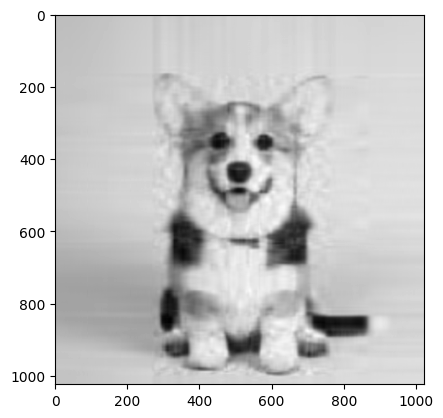

In [10]:
plt.imshow(A_, cmap='gray')

In [11]:
#Calculating the error
error = np.linalg.norm(A - A_)
error

7027.403659452569

In [12]:
def Accuracy(A: np.array, A_:np.array, tol:float):
    """
    A: Original matrix 
    A_: Approximated matrix 
    tol: Tolerance (+ve)
    """
    test = abs(A - A_) < tol
    count = np.sum(test)
    return count/(A.shape[0]*A.shape[1])


In [13]:
Accuracy(A, A_, 5)

0.774998664855957

##
<span style="font-family: 'Times New Roman'; font-size:20px">
<h3>
Applying Sampling on the Image Matrix
</h3>

In [14]:
A = load_image('image2.jpg', size=(1024,1024))

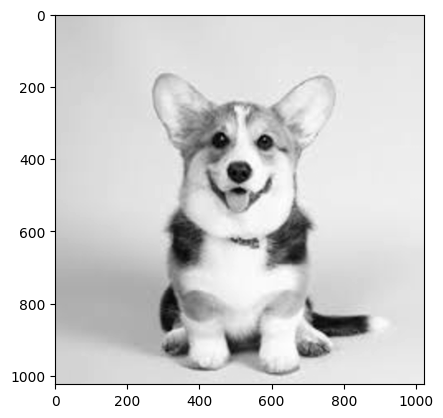

In [15]:
plt.imshow(A, cmap='gray')

In [16]:
def Random_Sampling(col_iter: zip, k: int, total_cols: int):
    """
    col_iter: Iterator of columns of the matrix
    k: Number of columns to be sampled
    """
    import random
    A = []
    col_num = sorted(random.sample(range(0,total_cols),k))
    
    for i, col in enumerate(col_iter):
        if i in col_num:
            A.append(col)
    return np.array(A).T, col_num
    

In [80]:
col_iter = zip(*A)
A_sampled,col_num = Random_Sampling(col_iter, 200, 1024)

In [81]:
A_sampled.shape

(1024, 200)

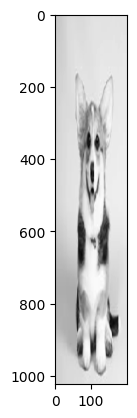

In [82]:
plt.imshow(A_sampled, cmap='gray')

In [83]:
def ALS_NNMF(A_sampled: np.array, n_components: int, col_num: np.array, true_size: tuple):
    n, m = true_size
    W = np.random.rand(n, n_components)
    H = np.random.rand(n_components, m)

    for i in range(n):
        col = 0
        row = []
        for j in range(len(col_num)):
            for _ in range(col, col_num[j]):
                row.append(0)
                col += 1
            WTW = W.T @ W
            H[:, col_num[j]] = np.linalg.lstsq(WTW, W.T @ A_sampled[:, j], rcond=None)[0]
            H[:, col_num[j]] = np.maximum(H[:, col_num[j]], 0)  # Enforce non-negativity
            row.append(A_sampled[i, j])
            col += 1
        HHT = H @ H.T
        W[i, :] = np.linalg.lstsq(HHT, H @ np.array(row).T, rcond=None)[0]
        W[i, :] = np.maximum(W[i, :], 0)
        if(i%100==0):
            print(f"Row {i} completed")

    return W, H


In [94]:
W__,H__= ALS_NNMF(A_sampled, 5, col_num, A.shape)

Row 0 completed
Row 100 completed
Row 200 completed
Row 300 completed
Row 400 completed
Row 500 completed
Row 600 completed
Row 700 completed
Row 800 completed
Row 900 completed
Row 1000 completed


In [95]:
W__.shape, H__.shape

((1024, 5), (5, 1024))

In [96]:
A_pred = W__ @ H__

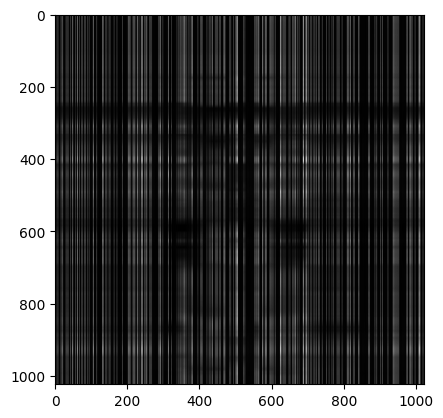

In [97]:
plt.imshow(A_pred, cmap='gray')

In [98]:
Accuracy(A, A_pred, 10)

0.05950164794921875